In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import os

In [16]:
def adjust_plot(ax, xrange, yrange, scaling=None, tick_freq=0.05):

    if type(tick_freq) is tuple:
        xtick_freq, ytick_freq = tick_freq[0], tick_freq[1]
    else:
        xtick_freq, ytick_freq = tick_freq, tick_freq

    if scaling == 'probit':
        h = scipy.stats.norm.ppf
    elif scaling == 'logit':
        h = lambda p: np.log(p / (1 - p))
    else:
        h = lambda p: p

    def transform(z):
        return [h(p) for p in z]

    tick_loc_x = [round(z, 2) for z in np.arange(xrange[0], xrange[1], xtick_freq)]
    ax.set_xticks(transform(tick_loc_x))
    ax.set_xticklabels([str(round(loc * 100)) for loc in tick_loc_x], fontsize=13)

    tick_loc_y = [round(z, 2) for z in np.arange(yrange[0], yrange[1], ytick_freq)]
    ax.set_yticks(transform(tick_loc_y))
    ax.set_yticklabels([str(round(loc * 100)) for loc in tick_loc_y], fontsize=13)

    z = np.arange(min(xrange[0], yrange[0]), max(xrange[1], yrange[1]), 0.01)

    ax.set_ylim(h(yrange[0]), h(yrange[1]))
    ax.set_xlim(h(xrange[0]), h(xrange[1]))

    ax.grid(linewidth=0.5)

    return transform
    

def plot(results_db_list, eval_dataset, save_path):
    fig, ax = plt.subplots()

    df = dict()
    finetuned = dict()
    wise_ft = dict()
    for results_db in results_db_list:
        df[results_db] = pd.read_json(results_db, lines=True)
        df[results_db] = df[[results_db]][df[results_db].alpha.apply(lambda x: isinstance(x, float))]
        try:
            zeroshot = df[results_db][df[results_db].alpha == 0]
        except:
            pass
        finetuned[results_db] = df[results_db][df[results_db].alpha == 1]
        wise_ft[results_db] = df[results_db][(df[results_db].alpha > 0) & (df[results_db].alpha < 1)]
    
    x = 'ImageNet:top1'
    y = f'{eval_dataset}:top1'

    min_x = min([df[key][x] for key in list(df.keys())])
    max_x = max([df[key][x] for key in list(df.keys())])
    min_y = min([df[key][y] for key in list(df.keys())])
    max_y = max([df[key][y] for key in list(df.keys())])

    x_range = (0.95 * min_x, 1.05 * max_x)
    y_range = (0.95 * min_y, 1.05 * max_y)

    transform = adjust_plot(ax, x_range, y_range, scaling=None)

    # Add zero-shot
    ax.scatter(
        transform(zeroshot[x]), transform(zeroshot[y]),
        label=f"CLIP zero-shot", marker='*', s=200, alpha=0.8, c='C4',
    )

    for results_db in results_db_list:
        # Add fine-tuned
        ax.scatter(
            transform(finetuned[results_db][x]), transform(finetuned[results_db][y]),
            label=f"CLIP fine-tuned", marker='D', s=100, alpha=0.8, c='C1',
        )

        # Add WiSE-FT
        ax.scatter(
            transform(wise_ft[results_db][x]), transform(wise_ft[results_db]    [y]),
            label=f"WiSE-FT", marker='d', s=100, alpha=0.8, c='C6',
        )

    ax.set_xlabel('In-distribution accuracy (ImageNet)', fontsize=16)
    ax.set_ylabel(f'OOD accuracy ({eval_dataset})', fontsize=16)
    ax.legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.13),
        ncol=3, fancybox=True
    )
    plt.savefig(save_path, bbox_inches='tight', transparent=False)

TypeError: unhashable type: 'list'

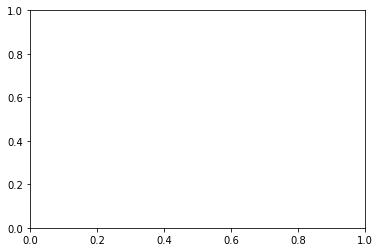

In [18]:
eval_datasets = ['ImageNetA', 'ImageNetSketch']
save = 'images/results'
results_db_list = ['/home/cihangxie/shaoyuan/wise-ft/results/end-to-end.jsonl',
                   '/home/cihangxie/shaoyuan/wise-ft/results/frozen2.jsonl',
                   '/home/cihangxie/shaoyuan/wise-ft/results/frozen4.jsonl',
                   '/home/cihangxie/shaoyuan/wise-ft/results/frozen6.jsonl',
                   '/home/cihangxie/shaoyuan/wise-ft/results/frozen8.jsonl',
                   '/home/cihangxie/shaoyuan/wise-ft/results/frozen10.jsonl',]
for eval_dataset in eval_datasets:
    save_path = os.path.join(save, f'{eval_dataset}.png')
    plot(results_db_list, eval_dataset, save_path)